In [22]:
########################################################################
# File            : $Id: $
# Version         : $Revision: 003 $
# Modified On     : $Date: 2nd Feb 2022$
# Service version : 1.1.9
# Language        : Python/Jupyter

## Unsupervised Anomaly Detection in Time Series Data

Many applications require being able to decide whether a new observation belongs to the same distribution as existing observations (it is an inlier), or should be considered as different (it is an outlier). Often, this ability is used to monitor the Assets.


The workflow of this notebook is as follows: <br>

1. [Provide Credential.](#packageLoad)
2. [Load Dataset.](#dataLoad)
3. [Compose Anomaly Service and Submit Job.](#pipelineCreation)
4. [Monitor Job](#thresholdstats)
5. [Result Analysis](#groundtruth)

### Credentials

This notebook requires two credentials. Please obtain your own credentials when customizing this notebook for your own work. Please visit __[Anomaly Detection @ IBM](https://developer.ibm.com/apis/catalog/ai4industry--anomaly-detection-product/Introduction)__ for trial subscription.

In [2]:
# Credentials required for running notebook

Client_ID = "replace-with-valid-client-ID"
Client_Secret = "replace-with-valid-client-Secret"


### Load Dataset<a id="dataLoad"></a>

In the data below, we have single sensor field representing values from one component. The actual meaning of the values isn't that important for the purpose of this example.

The task of anomaly detection is to predict either '1' or '-1' values along with anomaly score. Anomaly label '1' signifies that these samples at that time points are normals. Anomaly label '-1' means these samples are outliers or anomalous. Anomaly models are used to generate alarm in real time.

In [4]:
# try reading datasets from local files
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

datafile_name = 'sample.csv'
data_df = pd.read_csv("./datasets/univariate/sample_data/" + datafile_name)

data_df.head(10)

,Time,Value
0,2017-01-01 00:00:00,3.000000
1,2017-01-01 00:05:00,1.572558
2,2017-01-01 00:10:00,1.873181
3,2017-01-01 00:15:00,1.361140
4,2017-01-01 00:20:00,1.408475
5,2017-01-01 00:25:00,1.908858
6,2017-01-01 00:30:00,0.471416
7,2017-01-01 00:35:00,-0.755087
8,2017-01-01 00:40:00,-1.636673
9,2017-01-01 00:45:00,-0.663525


Below plot shows the sensor data for each of the variables, the user can also choose/resample data based upon the domain knowledge.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e8ad79450>],
      dtype=object)

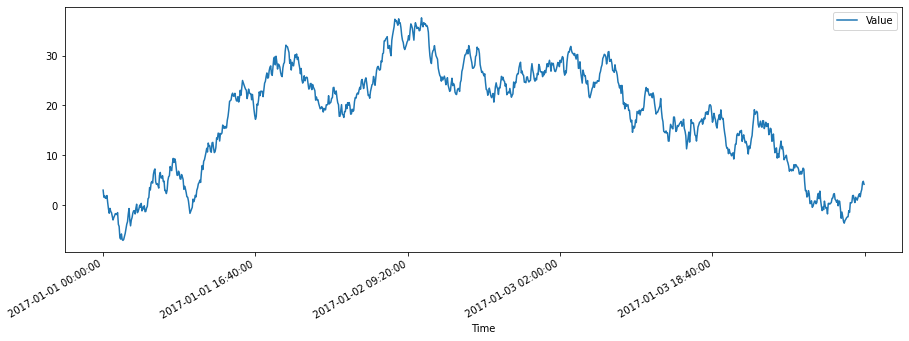

In [18]:
timestamp = "Time"
value = "Value"
time_format = '%Y-%m-%d %H:%M:%S'
data_df.plot(x=timestamp, y=value, subplots=True, figsize=(15, 5))

### Anomaly Service Creation and Job Submission <a id="pipelineCreation"></a>

Now, we compose anomaly service. User need to provide a local file name and some meta-data information about the data (target_column, time_column, time_format, etc). The detail of these parameters are available at __[IBM API Hub @ IBM](https://developer.ibm.com/apis/catalog/ai4industry--anomaly-detection-product/api/API--ai4industry--anomaly-detection-api#batch_uni)__ for Univariate Anomaly detection service.

In [7]:
file_path = './datasets/univariate/sample_data/' + datafile_name
files = {'data_file': (datafile_name, open(file_path, 'rb'))}

data = {
    'target_column': value,
    'time_column': timestamp,
    'time_format': time_format,
    'prediction_type': 'entire',
    'algorithm_type': 'DeepAD',
    'lookback_window': 'auto',
    'observation_window': 10,
    'labeling_method': 'Chi-Square',
    'labeling_threshold': 10,
    'anomaly_estimator': 'Default',
}

headers = {
    'X-IBM-Client-Id': Client_ID,
    'X-IBM-Client-Secret': Client_Secret,
    'accept': "application/json",
    }

import requests
post_response = requests.post("https://api.ibm.com/ai4industry/run/anomaly-detection/timeseries/univariate/batch", 
                              data=data,
                              files=files,
                              headers=headers)

post_r_json = post_response.json()
anomaly_service_jobId = None
if 'jobId' in post_r_json:
    anomaly_service_jobId = post_r_json['jobId']
    print ('submitted successfully job : ', post_r_json['jobId'])
else:
    print (post_r_json)

submitted successfully job :  26c402f5-67b5-4432-8b91-9a458eb09472


### Monitor Anomaly Job <a id="pipelineCreation"></a>

Each anomaly detection service call generates one job id. We now track the progress of job. Detail of job execution is covered at __[Get Result](https://developer.ibm.com/apis/catalog/ai4industry--anomaly-detection-product/api/API--ai4industry--anomaly-detection-api#get_result_by_id)__. You may need to the following cell at periodic interval.

In [19]:
get_response = requests.get("https://api.ibm.com/ai4industry/run/result/" + anomaly_service_jobId, headers=headers)
json_data = get_response.json()

print("the status of job {} is {}.".format(anomaly_service_jobId, json_data['status']))

the status of job 26c402f5-67b5-4432-8b91-9a458eb09472 is done.


### Anomaly Results <a id="groundtruth"></a>

Now we plot the anomaly score and anomaly label detected by the service.

In [20]:
result = []
result_header = ['timestamp', 'anomaly_score', 'anomaly_label']

for item in json_data['summary']['result']:
    result.append([item['timestamp'], item['value']['anomaly_score'][0], item['value']['anomaly_label'][0]])

result = pd.DataFrame(result)
result.columns = result_header
result.tail(10)

,timestamp,anomaly_score,anomaly_label
990,2017-01-04 10:30:00,0.000154,1.0
991,2017-01-04 10:35:00,0.009484,1.0
992,2017-01-04 10:40:00,0.013656,1.0
993,2017-01-04 10:45:00,0.020583,1.0
994,2017-01-04 10:50:00,0.540153,1.0
995,2017-01-04 10:55:00,0.594477,1.0
996,2017-01-04 11:00:00,0.438216,1.0
997,2017-01-04 11:05:00,1.541768,1.0
998,2017-01-04 11:10:00,-0.000458,1.0
999,2017-01-04 11:15:00,0.372137,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e8ae7e890>,
      dtype=object)

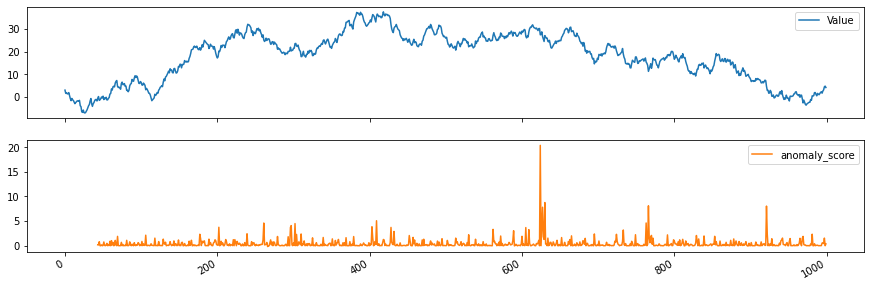

In [21]:
plot_data_df = data_df.copy()
plot_data_df['anomaly_score'] = result['anomaly_score']
plot_data_df[['Value','anomaly_score']].plot(subplots=True, figsize=(15, 5))